# Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Load dataset

In [5]:
df = pd.read_csv("online_retail_II.csv", encoding='ISO-8859-1')

In [6]:
print("Initial shape:", df.shape)

Initial shape: (1067371, 8)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [8]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


# Check Missing Value

In [10]:
missing = df.isnull().sum()
print("\nMissing values:\n", missing[missing > 0])


Missing values:
 Description      4382
Customer ID    243007
dtype: int64


In [11]:
# Drop rows with missing Customer ID or Description
df = df.dropna(subset=["Customer ID", "Description"])
print("\nAfter dropping nulls:", df.shape)

# Drop duplicates
print("Duplicates before:", df.duplicated().sum())
df.drop_duplicates(inplace=True)
print("Duplicates after:", df.duplicated().sum())


After dropping nulls: (824364, 8)
Duplicates before: 26479
Duplicates after: 0


# Feature Engineering

In [13]:
# Convert InvoiceDate to datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Total revenue per row
df["TotalRevenue"] = df["Quantity"] * df["Price"]

# Remove returns and errors (negative values)
df = df[(df["Quantity"] > 0) & (df["Price"] > 0)]

# Create YearMonth for time series
df["YearMonth"] = df["InvoiceDate"].dt.to_period("M")

# Revenue per order
df["RevenuePerOrder"] = df["TotalRevenue"] / df["Quantity"]

# Exploratory Data Analysis (EDA)

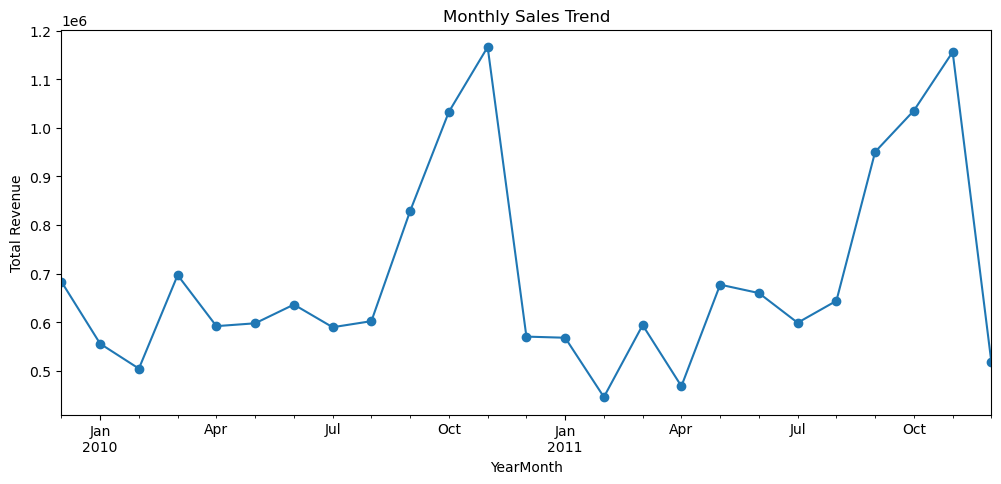

In [15]:
# Monthly sales trend
monthly_sales = df.groupby("YearMonth")["TotalRevenue"].sum()
monthly_sales.plot(figsize=(12, 5), title="Monthly Sales Trend", marker='o')
plt.ylabel("Total Revenue")
plt.show()

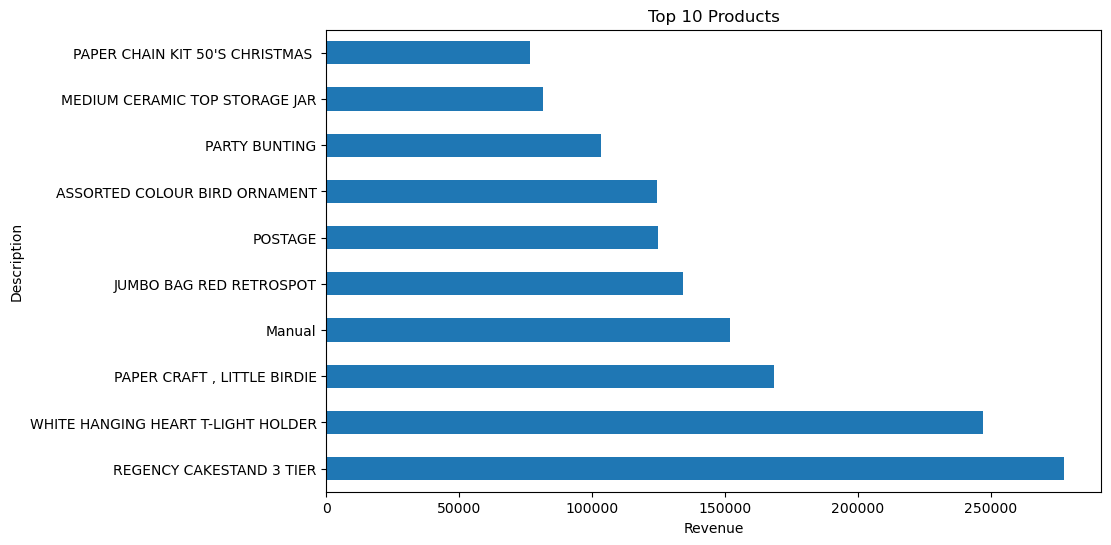

In [16]:
# Top 10 Products
top_products = df.groupby("Description")["TotalRevenue"].sum().sort_values(ascending=False).head(10)
top_products.plot(kind='barh', title="Top 10 Products", figsize=(10, 6))
plt.xlabel("Revenue")
plt.show()

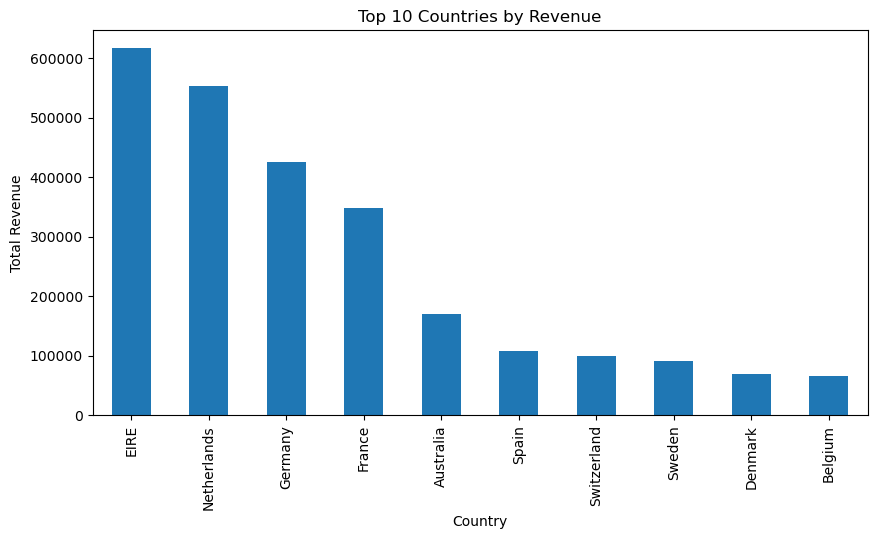

In [17]:
# Revenue by Country
country_revenue = df.groupby("Country")["TotalRevenue"].sum().sort_values(ascending=False)
country_revenue[1:11].plot(kind='bar', title="Top 10 Countries by Revenue", figsize=(10, 5))
plt.ylabel("Total Revenue")
plt.show()

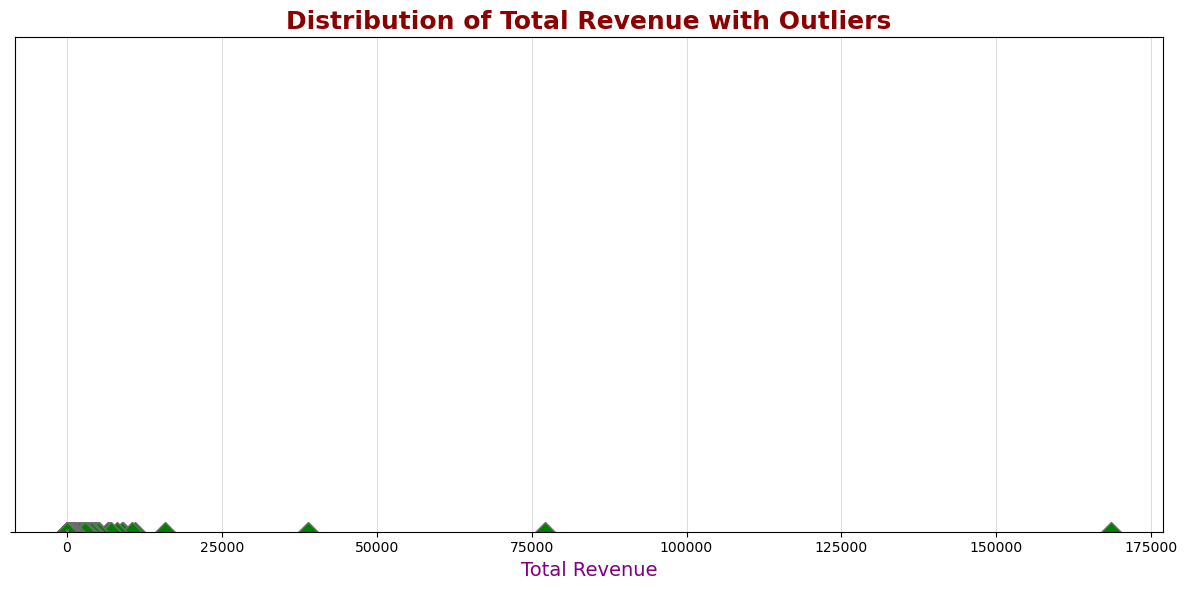

In [18]:
# Boxplot for Outlier Detection
plt.figure(figsize=(12, 6))
sns.boxplot(x=df["TotalRevenue"], color='lightcoral', linewidth=2, fliersize=10, flierprops=dict(marker='D', markerfacecolor='green', markersize=10))
plt.title("Distribution of Total Revenue with Outliers", fontsize=18, fontweight='bold', color='darkred')
plt.xlabel("Total Revenue", fontsize=14, fontweight='medium', color='purple')
plt.ylim(0, df["TotalRevenue"].quantile(0.95)) 
plt.grid(True, linestyle='-', linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()

# Customer Segmentation (Clustering)

In [20]:
# Aggregate customer data
customer_features = df.groupby("Customer ID").agg({
    "Invoice": "nunique",
    "TotalRevenue": "sum",
    "Quantity": "sum"
}).rename(columns={
    "Invoice": "NumOrders",
    "TotalRevenue": "TotalSpent",
    "Quantity": "TotalUnits"
})
customer_features["AvgOrderValue"] = customer_features["TotalSpent"] / customer_features["NumOrders"]

# Scale features
scaler = StandardScaler()
scaled = scaler.fit_transform(customer_features)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
customer_features["Segment"] = kmeans.fit_predict(scaled)
customer_features.head()

,NumOrders,TotalSpent,TotalUnits,AvgOrderValue,Segment
Customer ID,,,,,
12346.0,12,77556.46,74285,6463.038333,2
12347.0,8,4921.53,2967,615.191250,0
12348.0,5,2019.40,2714,403.880000,0
12349.0,4,4428.69,1624,1107.172500,0
12350.0,1,334.40,197,334.400000,0


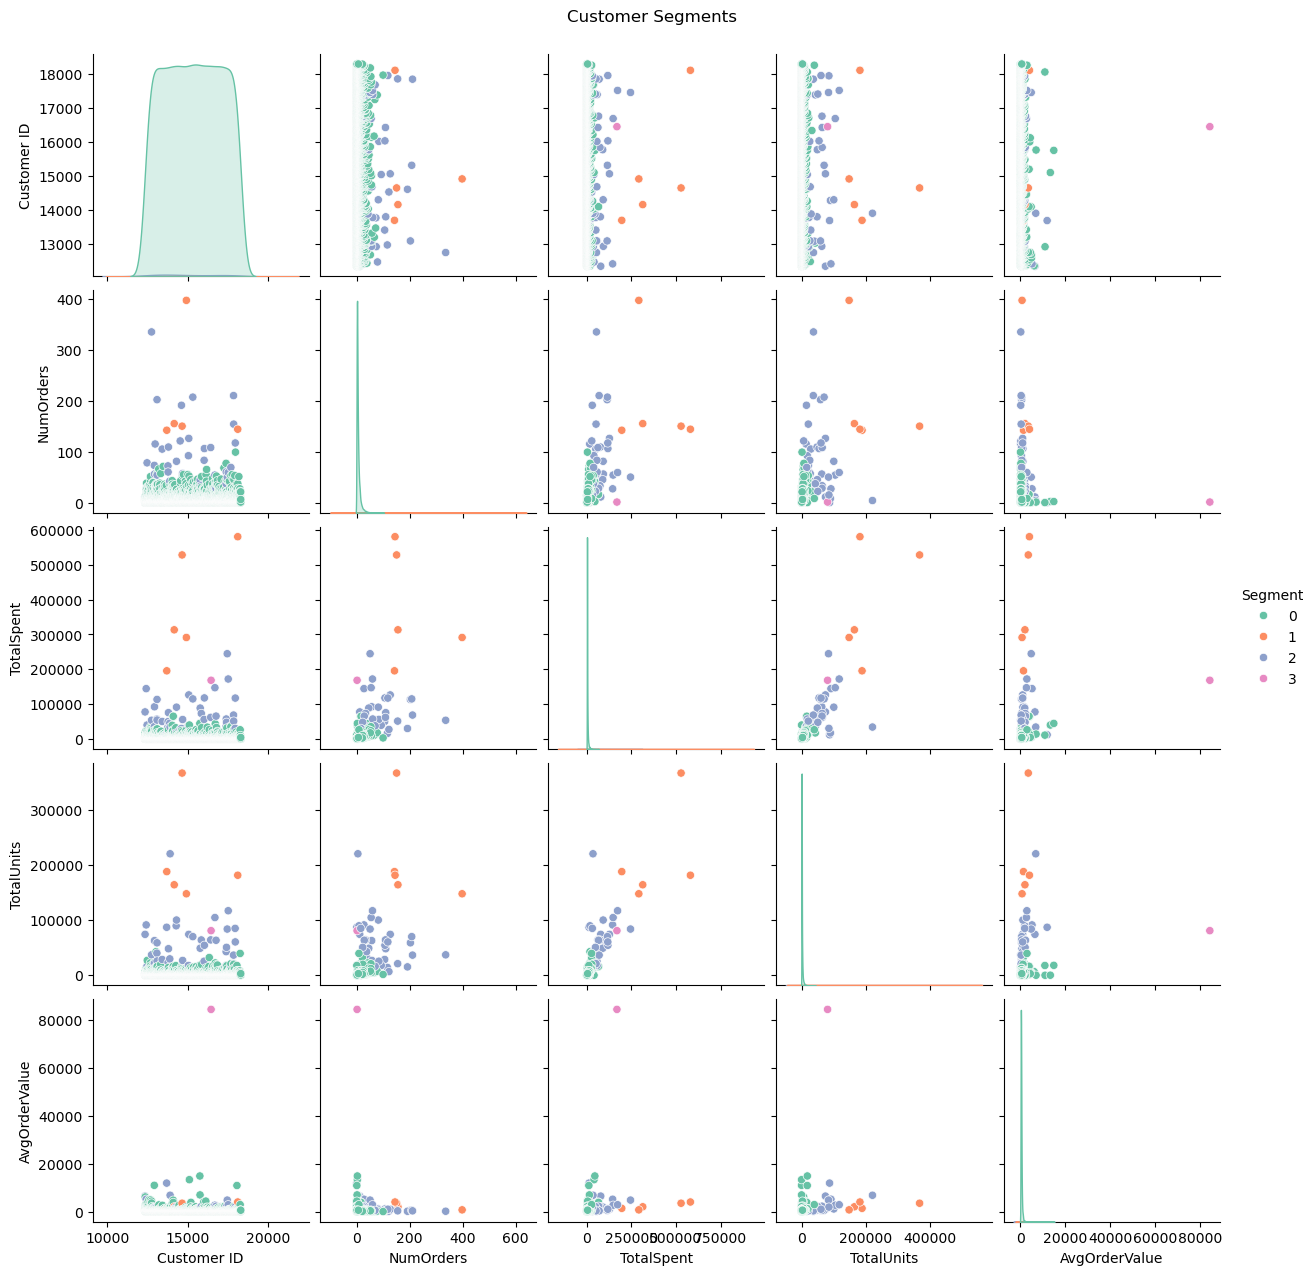

In [21]:
sns.pairplot(customer_features.reset_index(), hue="Segment", palette="Set2", diag_kind="kde")
plt.suptitle("Customer Segments", y=1.02)
plt.show()

# Forecasting (ARIMA)

In [23]:
monthly_ts = monthly_sales.astype(float)

model = ARIMA(monthly_ts, order=(1, 1, 1))
model_fit = model.fit()

# Forecast next month
forecast = model_fit.forecast(steps=1)
print("Predicted revenue for next month:", forecast[0])

Predicted revenue for next month: 598362.1611408652


In [24]:
# Define HighValue label
customer_features["HighValue"] = (customer_features["TotalSpent"] > customer_features["TotalSpent"].median()).astype(int)

# Prepare data
X = customer_features.drop(["Segment", "HighValue"], axis=1)
y = customer_features["HighValue"]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train model
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb.fit(X_train, y_train)

# Predict
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       904
           1       1.00      1.00      1.00       860

    accuracy                           1.00      1764
   macro avg       1.00      1.00      1.00      1764
weighted avg       1.00      1.00      1.00      1764

